In [13]:
import  typing
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from tqdm import tqdm

from utils import MultiLayerPerceptron
from utils import clamp
from utils import entropic_loss
from utils import european_option_delta
from utils import generate_geometric_brownian_motion,generate_heston_brownian_motion
from utils import to_premium

In [3]:
import numpy as np
import matplotlib
from matplotlib import  pyplot as plt

In [4]:
def check_gpu():
    is_cuda = torch.cuda.is_available()
    if is_cuda:
        device = torch.device("cuda")
        print("GPU is avaiavle.")
    else:
        device = torch.device("cpu")
        print("Using CPU, GPU is not available.")
    return device

In [5]:
device = check_gpu()

Using CPU, GPU is not available.


In [206]:
class RNN(nn.Module):
    def __init__(self, in_dim:int,out_dim:int,hidden_size:int,n_layers=1):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(in_dim,hidden_size,batch_first=False,nonlinearity='relu')
        self.fc = nn.Linear(hidden_size,out_dim)
        self.device = self.check_gpu()
    def check_gpu(self):
        is_cuda = torch.cuda.is_available()
        if is_cuda:
            device = torch.device("cuda")
            print("GPU is avaiavle.")
        else:
            device = torch.device("cpu")
            print("Using CPU, GPU is not available.")
        return device
    def forward(self,x):
        out, _  = self.rnn(x)
        return out

class RNN_NTB(RNN):
    def __init__(self,in_dim:int,out_dim:int,model:str,n_layers=1):
        self.model = model
        if self.model == 'BS':
            hidden_size = 2
        elif self.model == 'Heston':
            hidden_size = 4
        else:
            raise ValueError("We only have two modoles: BS or Heston, please check your input.")
        super(RNN_NTB,self).__init__(in_dim,out_dim,hidden_size,n_layers)
    def forward(self,x):
        out, _ = self.rnn(x)
        if self.model == 'BS':
            hedge = torch.zeros((out.shape[0]+1,out.shape[1],1))
            for i in range(1,hedge.shape[0]):
                tmp = torch.cat((out[i-1,:,0],out[i-1,:,1],hedge[i-1,:,0]),dim=-1)
                hedge[i] = torch.median(tmp,dim=-1,keepdim=True)[0]
        else :
            hedge = torch.zeros((out.shape[0]+1,out.shape[1],2))
            for i in range(1,hedge.shape[0]):
                tmp_s = torch.cat((out[i-1,:,0],out[i-1,:,1],hedge[i-1,:,0]),dim=-1)
                tmp_v = torch.cat((out[i-1,:,2],out[i-1,:,3],hedge[i-1,:,1]),dim=-1)
                hedge_s = torch.median(tmp_s,dim=-1,keepdim=True)[0]
                hedge_v = torch.median(tmp_v,dim=-1,keepdim=True)[0]
                hedge[i] = torch.cat((hedge_s,hedge_v),dim=-1)
        return hedge[1:,:,:]

In [207]:
import  seaborn as sns
sns.set_style("whitegrid")

FONTSIZE = 18
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 50000
# How many times a model is updated in the experiment.
N_EPOCHS = 200

def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

In [208]:
def european_option_payoff(prices: torch.Tensor, strike=1.0) -> torch.Tensor:
    """
    Return the payoff of a European option.

    Parameters
    ----------
    prices : torch.Tensor, shape (n_steps, n_paths)
        Prices of the underlying asset.

    Returns
    -------
    payoff : torch.Tensor, shape (n_paths, )
    """
    return fn.relu(prices[-1, :] - strike)

def lookback_option_payoff(prices: torch.Tensor, strike=1.03) -> torch.Tensor:
    """
    Return the payoff of a lookback option.

    Parameters
    ----------
    prices : torch.Tensor, shape (n_steps, n_paths)
        Prices of the underlying asset.

    Returns
    -------
    payoff : torch.Tensor, shape (n_paths, )
    """
    return fn.relu(torch.max(prices, dim=0).values - strike)

In [209]:
def compute_profit_and_loss(
    hedging_model: torch.nn.Module,
    payoff: typing.Callable[[torch.Tensor], torch.Tensor],
    cost: float,
    n_paths=N_PATHS,
    maturity=30 / 365,
    dt=1 / 365,
    volatility=0.2,
) -> torch.Tensor:

    # Prepare time-series of prices with shape (time, batch)
    prices = generate_geometric_brownian_motion(
        n_paths, maturity=maturity, dt=dt)
    prices = prices.reshape((prices.shape[0],prices.shape[1],1))

    # Simulate hedging over time.
    x_log_moneyness = prices[:, :, :].log()
    x = torch.cat([x_log_moneyness], 1)

    hedge = hedging_model(x)
    pnl = 0

    for i in range(1,hedge.shape[0]):
    # Receive profit/loss from the original asset.
        pnl += hedge[i] * (prices[i] - prices[i-1])
    # Pay transaction cost.
        pnl -= cost * torch.abs(hedge[i] - hedge[i-1]) * prices[i]

    # Pay the option's payoff to the customer.
    pnl -= payoff(prices)
    return pnl


In [210]:
maturity=30
rnn_bs = RNN(in_dim=1,out_dim=1,hidden_size=1).to(DEVICE)
rnn_ntb_bs = RNN_NTB(in_dim=1,out_dim=1,model='BS').to(DEVICE)

Using CPU, GPU is not available.
Using CPU, GPU is not available.


In [211]:
pnl = compute_profit_and_loss(hedging_model=rnn_bs,payoff=european_option_payoff,cost=1e-3)
pnl_ntb_bs = compute_profit_and_loss(hedging_model=rnn_ntb_bs,payoff=european_option_payoff,cost=1e-3)

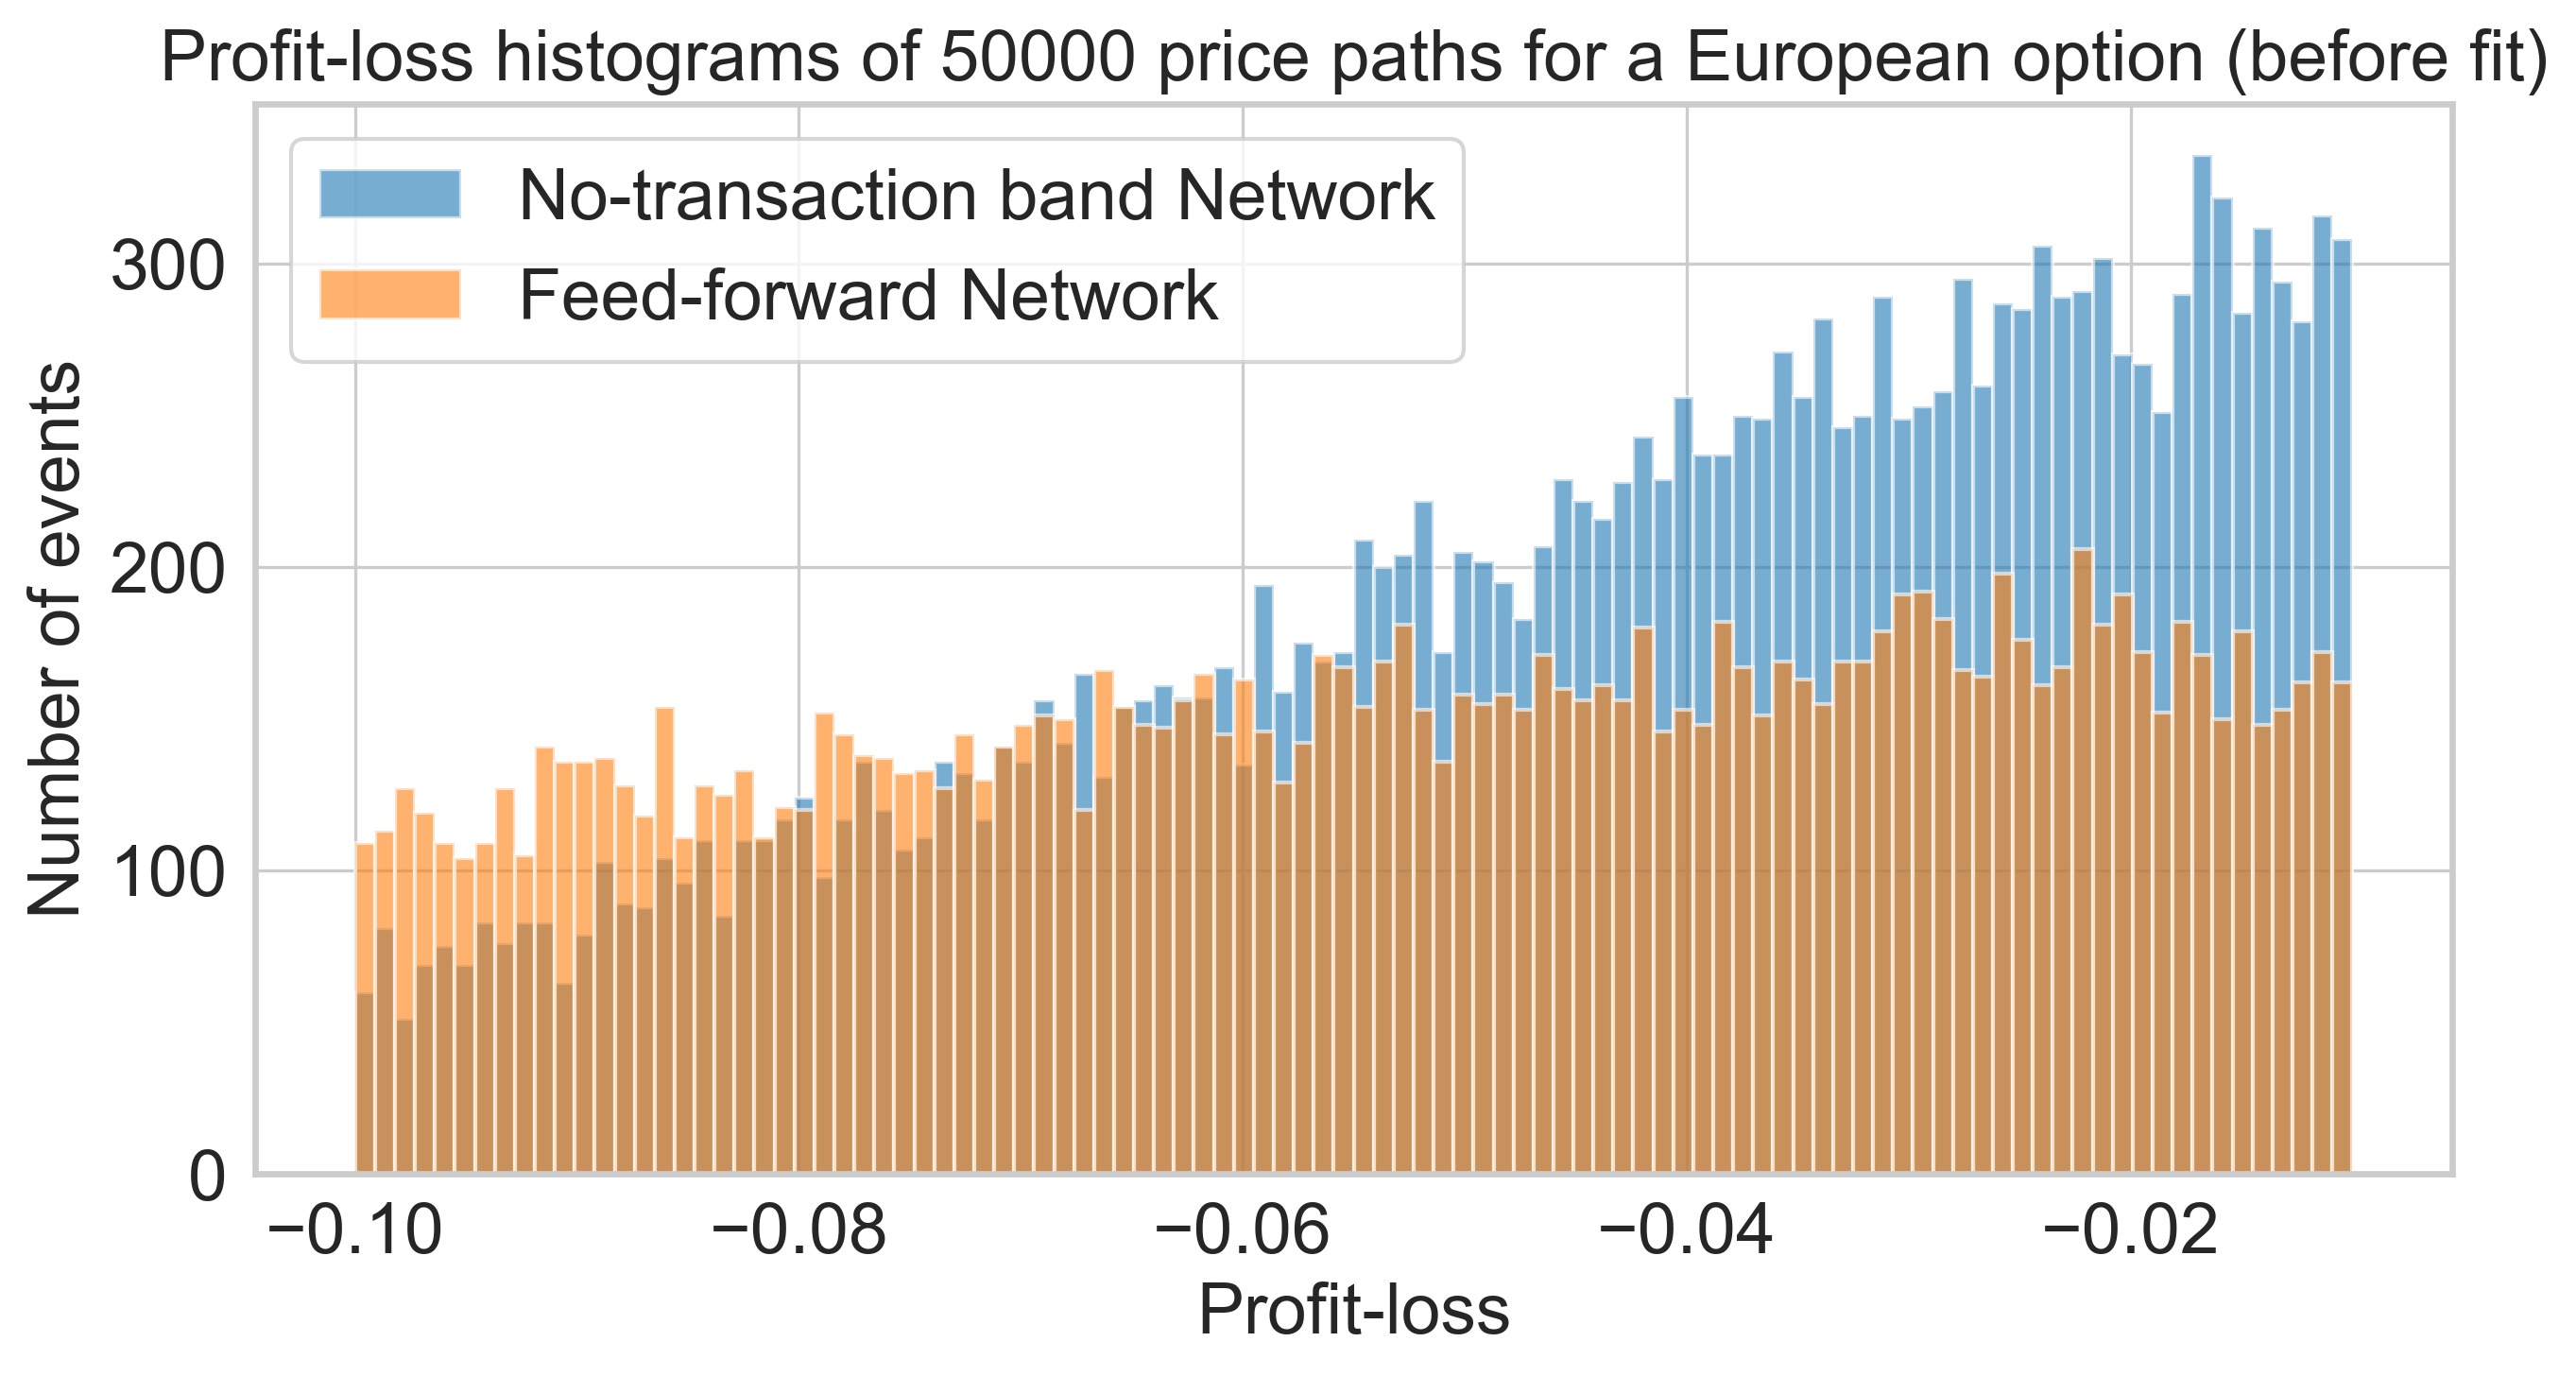

In [212]:
plt.figure()
plt.hist(
    to_numpy(pnl_ntb_bs),
    bins=100,
    range=(-0.1, -0.01),
    alpha=0.6,
    label="No-transaction band Network",
)
plt.hist(
    to_numpy(pnl),
    bins=100,
    range=(-0.1, -0.01),
    alpha=0.6,
    label="Feed-forward Network",
)

plt.title(
    "Profit-loss histograms of 50000 price paths for a European option (before fit)"
)
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.legend()
plt.show()

In [213]:
def fit(
    hedging_model: torch.nn.Module,
    payoff: typing.Callable[[torch.Tensor], torch.Tensor],
    cost: float,
    n_epochs=N_EPOCHS,
) -> list:

    optim = Adam(hedging_model.parameters())

    loss_history = []
    progress = tqdm(range(n_epochs))

    for _ in progress:
        optim.zero_grad()
        pnl = compute_profit_and_loss(hedging_model, payoff, cost=cost)
        loss = entropic_loss(pnl)
        loss.backward()
        optim.step()

        progress.desc = f"Loss={loss:.5f}"
        loss_history.append(loss.item())

    return loss_history

In [ ]:
COST = 1e-3
torch.manual_seed(42)
history_ntb_eu = fit(rnn_ntb_bs, european_option_payoff, cost=COST)
torch.manual_seed(42)
history_ffn_eu = fit(rnn_bs, european_option_payoff, cost=COST)




Loss=1.02249:  64%|██████▍   | 129/200 [02:40<01:29,  1.26s/it]

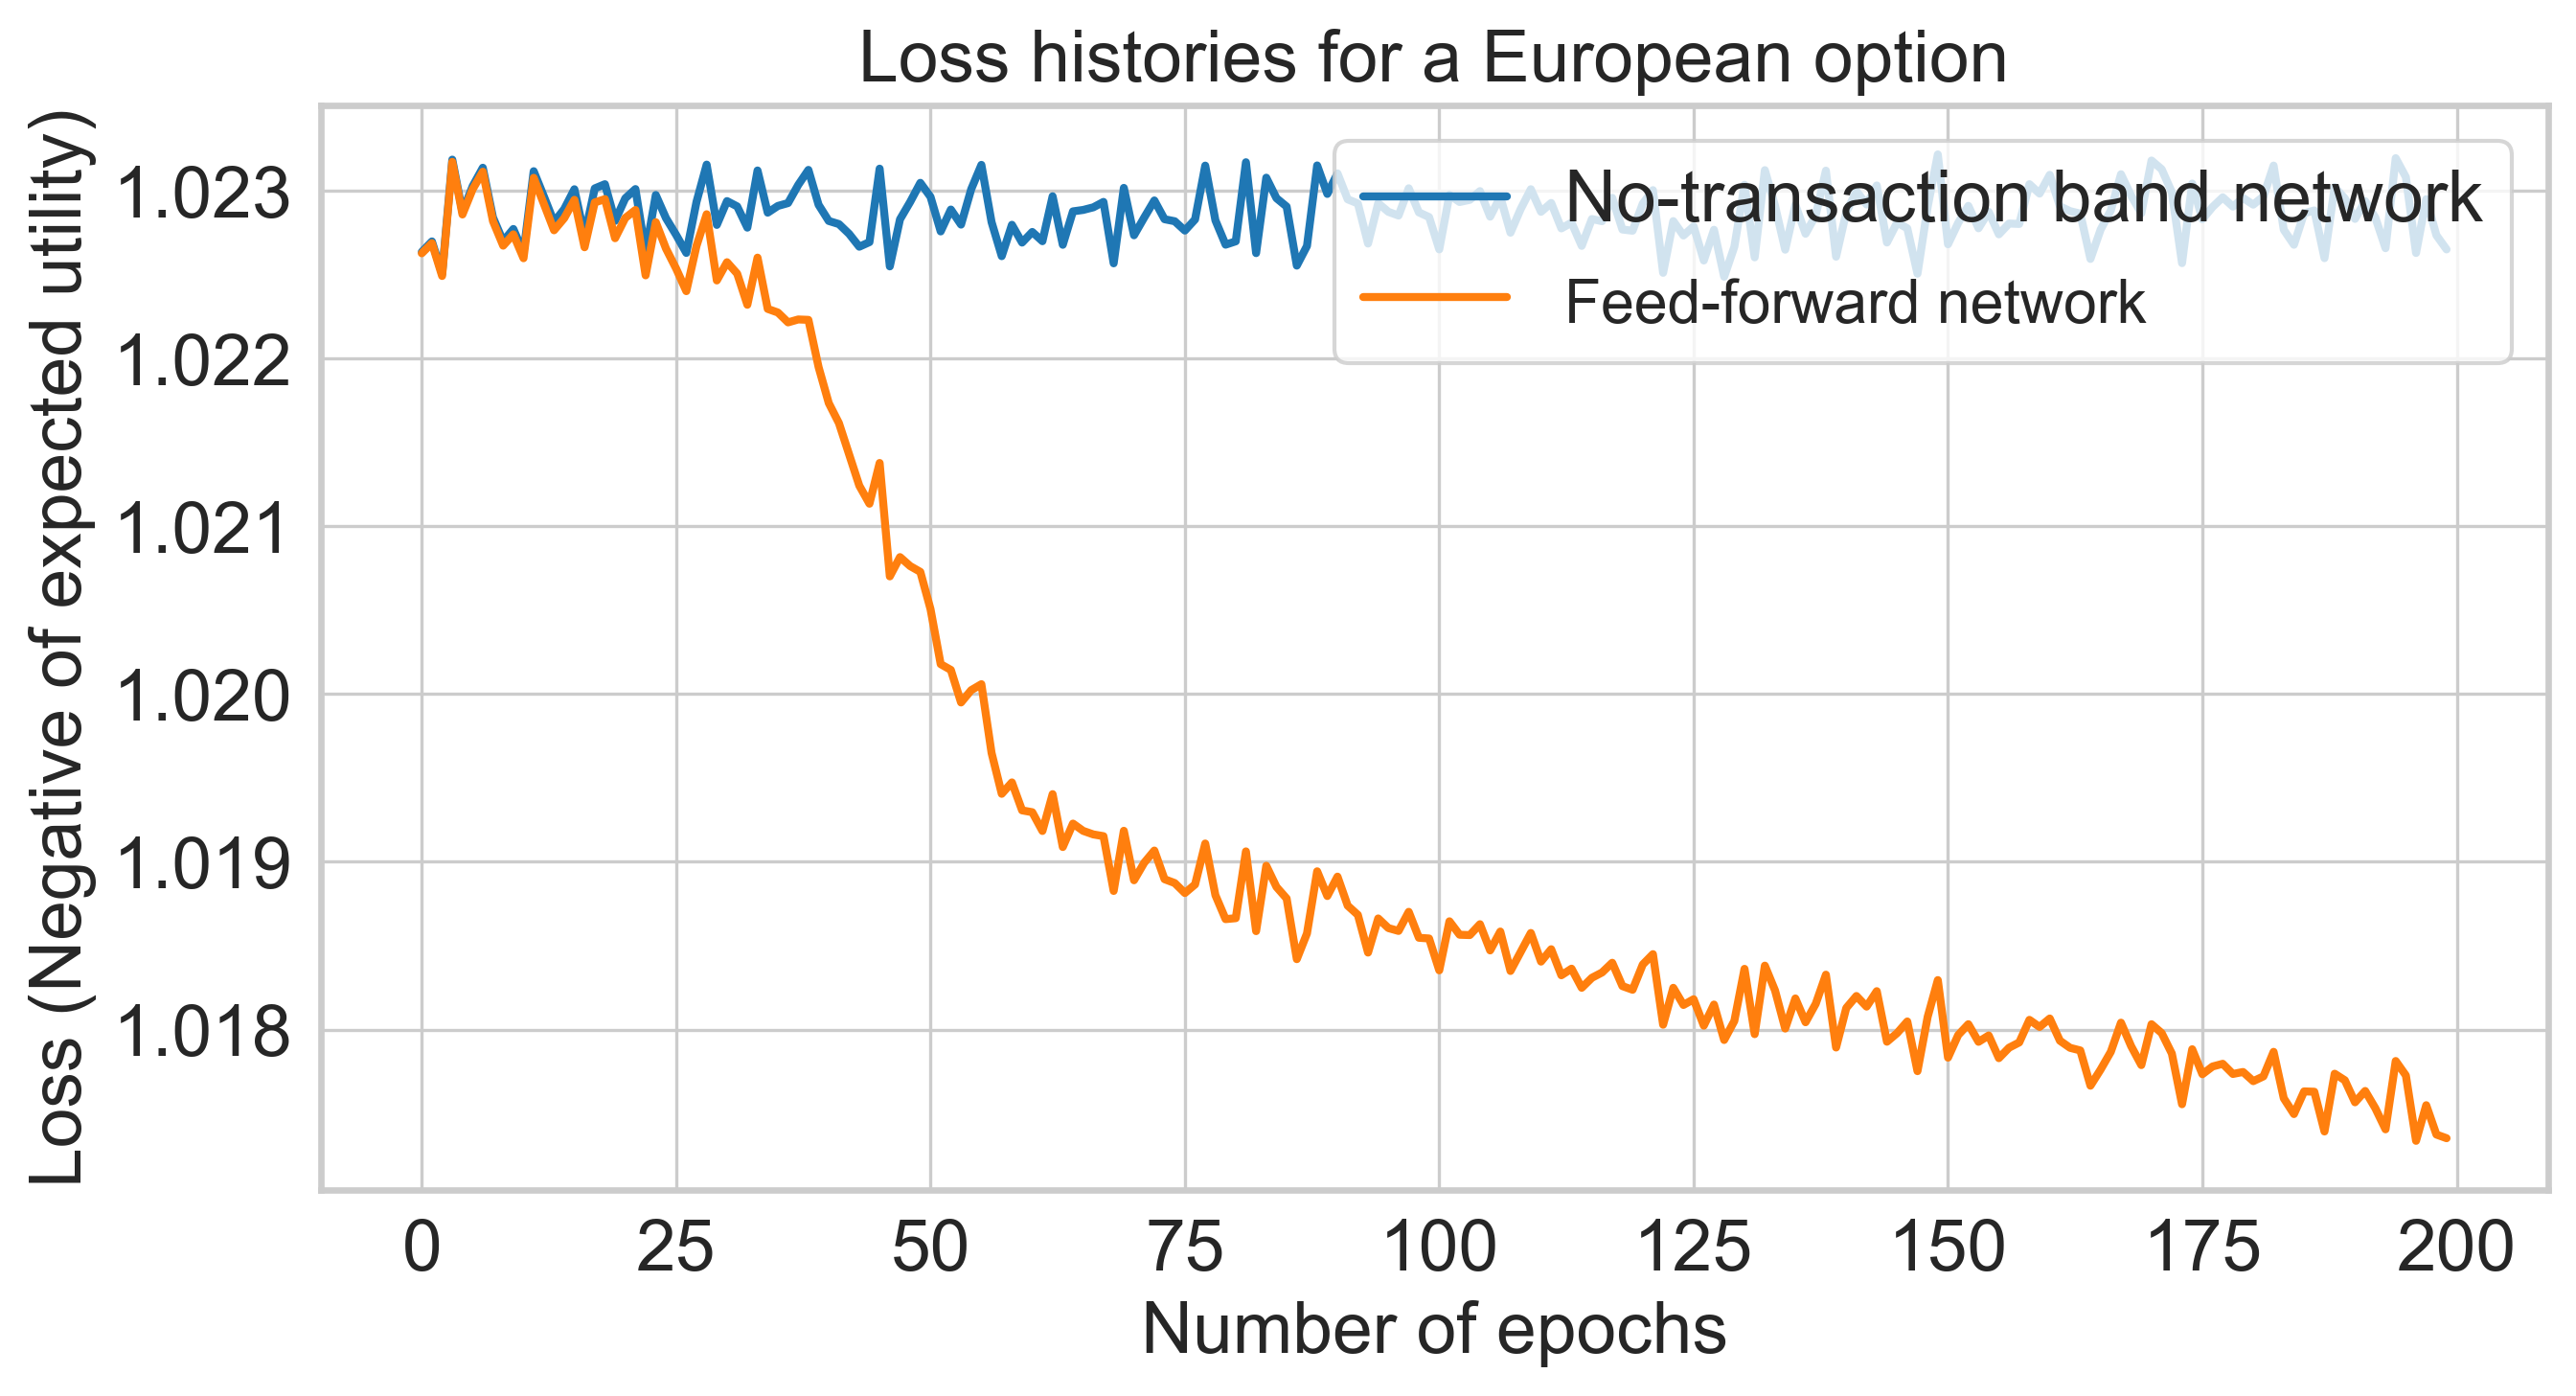

In [193]:
plt.figure()
plt.plot(history_ntb_eu, label="No-transaction band network")
plt.plot(history_ffn_eu, label="Feed-forward network")
plt.xlabel("Number of epochs")
plt.ylabel("Loss (Negative of expected utility)")
plt.title("Loss histories for a European option")
legend = plt.legend(loc=1)
text = legend.get_texts()[1]
text.set_fontsize(15)
plt.show()

In [ ]:

pnl_ntb = compute_profit_and_loss(rnn_ntb_bs, european_option_payoff, cost=COST)
pnl_ffn = compute_profit_and_loss(rnn_bs, european_option_payoff, cost=COST)


plt.figure()
plt.hist(
    [to_numpy(pnl_ntb)],
    bins=100,
    range=(-0.12, 0.01),
    alpha=1,
    label=["No-transaction band network"]
)
plt.hist(
    to_numpy(pnl_ffn),
    bins=100,
    range=(-0.12, 0.01),
    alpha=0.6,
    label="Feed-forward network",
)
plt.title(
    "Profit-loss histograms of 50000 price paths for a European option (after fit)"
)
plt.xlabel("PnL")
plt.ylabel("Number of events")
plt.legend()
plt.show()